In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Lets look at the data

* Work Order Number ----------------------------------------- 12939001 (como una factura, el trabajo realizado se almacenaba como un número)
* Site Number -------------------------------------------------- A0052 (cada tienda que mantiene la empresa tiene un número
)
* Site Type ---------------------------------------------- SUPERMARKET (Tipo de tienda: Supermercado (grande) / Conveniencia (pequeña))
* Date Created -------------------------------------- 02/02/2012 09:45 (fecha y hora en que se produjo la alarma)
* Date Completed ----------------------------------- 02/02/2012 21:10 (fecha y hora en que se silenció la alarma)
* Provider Name ------------------------------- CMS Solutions Limited (nombre de la empresa de mantenimiento)
* WO Current Status ---------------------------------------------- EOL (no recuerdo)
* Asset Category --------------------------------------- REFRIGERATION (tipo de activo, también arreglan aire acondicionado, luz, etc.)
* Problem Type Name ---------- Fixture Critical Over Temperature Alarm (tipo de alarma)
* Requested By ---------------------------- Urgent Refrigeration Alarm (prioridad de la alarma)
* WO Priority ------------------------------------------- Standard SLA (para la contabilidad de la empresa)
* Manufacturer ---------------------------------------------- LINDE AG (fabricante del activo que hizo la alarma)
* Asset In-Service Date ----------------------------- 23/05/2012 05:00 (cuando la máquina se conectó por primera vez)
* Level 1 Organization Name ------------------------------- Region S01 (la empresa dividió el país en regiones)
* Site Zipcode ----------------------------------------------- CR0 4XT (código postal de la tienda - ayuda a localizarla)
* Sales Sq. Ft. ---------------------------------------------- 48409.0 (el tamaño de la tienda en pies cuadrados)
* Asset Barcode ------------------------------------------ SSL00319496 (número del asado (nevera), una etiqueta)
* Client Product Name -------------------------------------------- NaN (no recuerdo)
* Asset Type ---------------------------------------- REMOTE MULTIDECK (El frigorífico puede ser abierto, cerrado, armario, etc.)
* Asset Status ---------------------------------------------- Inactive (¿El activo está activo hoy? Hora de generar el conjunto de datos)

In [2]:
data = pd.read_csv("CPT_PREDICTIVE_PPM.csv",encoding='windows-1252')
data.head(3)

,Work Order Number,Site Number,Site Type,Date Created,Date Completed,Provider Name,WO Current Status,Asset Category,Problem Type Name,Requested By,WO Priority,Manufacturer,Asset In-Service Date,Level 1 Organization Name,Site Zipcode,Sales Sq. Ft.,Asset Barcode,Client Product Name,Asset Type,Asset Status
0,12904684,A0892,SUPERMARKET,01/02/2012 03:05,01/02/2012 10:00,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567391,Frozen Food (-18C or less),HALF GLASS DOOR & WELL,In Service
1,12904685,A0892,SUPERMARKET,01/02/2012 03:05,01/02/2012 09:59,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567398,Frozen Food (-18C or less),FULL GLASS DOOR,In Service
2,12904853,A0892,SUPERMARKET,01/02/2012 05:10,01/02/2012 10:01,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567399,Frozen Food (-18C or less),FULL GLASS DOOR,In Service


In [3]:
# Columnas que no aportan para la prediccion
#work order number
#site number
#wo current status
col = []
for columns in data.columns:
    temp = columns.replace(" ","_")
    temp = temp.replace("-","_")
    temp = temp.replace(".","")
    temp = temp.lower()
    col.append(temp)
data.columns = col
data.head()

,work_order_number,site_number,site_type,date_created,date_completed,provider_name,wo_current_status,asset_category,problem_type_name,requested_by,wo_priority,manufacturer,asset_in_service_date,level_1_organization_name,site_zipcode,sales_sq_ft,asset_barcode,client_product_name,asset_type,asset_status
0,12904684,A0892,SUPERMARKET,01/02/2012 03:05,01/02/2012 10:00,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567391,Frozen Food (-18C or less),HALF GLASS DOOR & WELL,In Service
1,12904685,A0892,SUPERMARKET,01/02/2012 03:05,01/02/2012 09:59,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567398,Frozen Food (-18C or less),FULL GLASS DOOR,In Service
2,12904853,A0892,SUPERMARKET,01/02/2012 05:10,01/02/2012 10:01,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567399,Frozen Food (-18C or less),FULL GLASS DOOR,In Service
3,12927899,A0416,SUPERMARKET,01/02/2012 08:40,02/02/2012 13:03,CMS Solutions Limited,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,LINDE,01/08/2002 05:00,Region S01,BR4 0PU,13423.0,SSL00225160,"Meat, Fish and Poultry (3C or less)",REMOTE MULTIDECK,In Service
4,12932231,A0003,SUPERMARKET,01/02/2012 13:33,08/02/2012 19:39,CMS Solutions Limited,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,RADFORD RETAIL SYSTEMS,15/03/2009 04:00,Region S02,DA11 8JH,37870.0,SSL00583503,NaN,FULL GLASS DOOR,Scrapped


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609989 entries, 0 to 609988
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   work_order_number          609989 non-null  int64  
 1   site_number                609989 non-null  object 
 2   site_type                  609989 non-null  object 
 3   date_created               609989 non-null  object 
 4   date_completed             577602 non-null  object 
 5   provider_name              609989 non-null  object 
 6   wo_current_status          609989 non-null  object 
 7   asset_category             609989 non-null  object 
 8   problem_type_name          609989 non-null  object 
 9   requested_by               527644 non-null  object 
 10  wo_priority                609989 non-null  object 
 11  manufacturer               609989 non-null  object 
 12  asset_in_service_date      506751 non-null  object 
 13  level_1_organization_name  60

¿Por qué hay datos incompletos en date_completed?

Tres posibilidades

* La nevera ya no pudo ser arreglada
* La nevera se arregló y quien completa los datos olvidó registrarlo
* La alarma salta pero no hay un fallo en la nevera sino en la alarma

Se le sugiere al administrador recolectar datos de fallos en la alarma y registrarlos, con esto las predicciones para la cantidad de refrigeradores que se dañarán en el futuro podría mejorar.

In [5]:
#Podemos visualizar cuales son las tiendas en las que más refrigeradores se dañan
data["site_type"].value_counts()

SUPERMARKET             444356
CONVENIENCE STORE       105334
SHARED SITE              46831
DEPOT                     7179
PFS                       6271
STORE SUPPORT CENTRE        16
CENTRAL LOCATION             2
Name: site_type, dtype: int64

<AxesSubplot:xlabel='site_type', ylabel='count'>

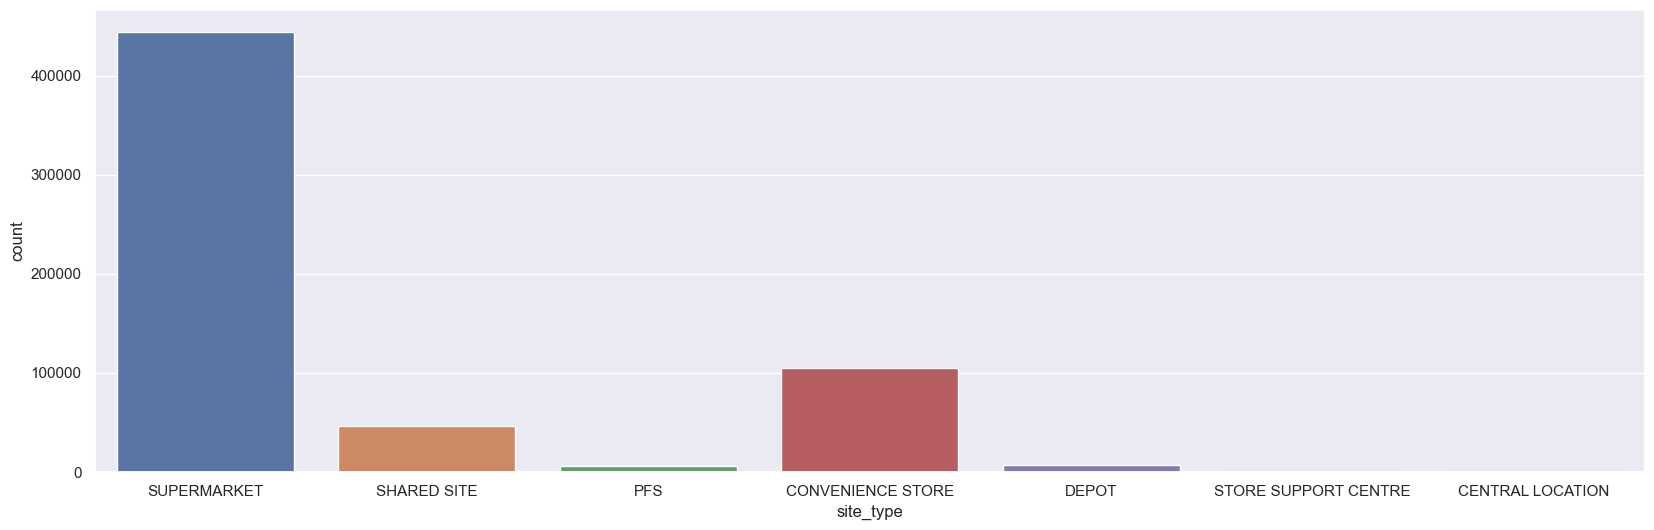

In [6]:
sns.set(rc={"figure.figsize":(20, 6)}) # tamano del plot
sns.countplot(data=data, x='site_type')

¿Por qué se dañan más refrigeradores en los supermercados?

Pueden ser las siguientes razones...

* Se les da más uso
* Los refrigeradores son más grandes y tienen un mecanismo de enfriamiento diferente con menos vida útil
* Hay más de un refrigerador por tienda

¿El tamaño de la nevera puede influir en los daños que sufre el refrigerador por el método de funcionamiento?

* Se puede recolectar una columna donde se clasifique la nevera (Grande, Mediano, Pequeño) o en Litros
* También se podria recolectar información sobre el tipo de falla que presentó la nevera (Bajo voltaje, fusible quemado, termostato descompuesto, etc ) y mirar si hay correlación con los posibles daños en cada tipo de refrigerador

In [7]:
# Qué marcas o modelos de refrigeradores se dañan más
data["asset_barcode"].value_counts().nlargest(10)

No Asset       83984
SSL00924359      346
SSL00924224      260
SSL00495394      246
SSL00807340      224
SSL00495477      218
SSL00924225      217
SSL00613489      215
SSL00229210      206
SSL00676611      201
Name: asset_barcode, dtype: int64

In [8]:
data2=data[data['asset_barcode']=="SSL00924359"]
data2["site_number"].unique()

array(['A4344'], dtype=object)

El modelo "SSL00924359" pertenece a la misma tienda "A4344" y se ha dañado 346 veces podriamos sugerirle a la tienda cambiar la nevera. 

In [9]:
letras_code = []
num_code = []

for i in range(len(data)):
    try:
        letra=re.findall(r'\w{3}',data["asset_barcode"][i])[0]
        letras_code.append(letra)
    except:
        letras_code.append("NoL")

In [10]:
data1=data
data1.insert(0,"lyrics_code",letras_code)

In [12]:
data=data.drop(['lyrics_code'],axis=1) # No se por que se modifico el data, elimino el lyrics_code del data

In [15]:
data1["lyrics_code"].unique()

array(['SSL', 'ssl', 'A06', 'Ass', 'NoL', '760', 'SSl', 'SS0', 'SLL',
       '535', '174'], dtype=object)

In [16]:
data1["lyrics_code"].value_counts() # Los modelos SSL son los que más se usan

SSL    525553
Ass     83984
ssl       373
A06        23
SSl        23
NoL        16
SLL        12
SS0         2
760         1
535         1
174         1
Name: lyrics_code, dtype: int64

In [22]:
#Podemos visualizar tambien los tipos de nevera que más se dañan
data["asset_type"].value_counts().nlargest(10)

REMOTE MULTIDECK          217207
COLDROOM CONTROL PANEL     59688
FULL GLASS DOOR            42707
HALF GLASS DOOR & WELL     35840
COLDROOM EVAPORATOR        29203
WELL                       24799
SERVE OVER                 17254
INTEGRAL FREEZER           16160
HALF GLASS DOOR            15737
INTEGRAL CHILLER           14649
Name: asset_type, dtype: int64

los refrigeradores "REMOTE MULTIDECK" son muy sensibles y se dañan más

In [23]:
#Podemos visualizar tambien los tipos de nevera que menos se dañan
data["asset_type"].value_counts().nsmallest(10)

INTEGRAL CHEST FREEZER              1
MEAT COUNTER                        1
COLDROOM AIR CURTAIN                2
CAFE CABINET                        3
INTEGRAL HALF GLASS DOOR & WELL     3
ONLINE FREEZER                      4
CHEESE COUNTER                      4
REFRIGERANT LEAK DETECTION PANEL    7
INTEGRAL REFRIGERATED CUPBOARD      9
HALF GLASS DOOR & WELL END          9
Name: asset_type, dtype: int64

In [24]:
data1['date_created'] = pd.to_datetime(data1['date_created'])

In [26]:
data1.head()

,lyrics_code,work_order_number,site_number,site_type,date_created,date_completed,provider_name,wo_current_status,asset_category,problem_type_name,...,wo_priority,manufacturer,asset_in_service_date,level_1_organization_name,site_zipcode,sales_sq_ft,asset_barcode,client_product_name,asset_type,asset_status
0,SSL,12904684,A0892,SUPERMARKET,2012-01-02 03:05:00,01/02/2012 10:00,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,...,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567391,Frozen Food (-18C or less),HALF GLASS DOOR & WELL,In Service
1,SSL,12904685,A0892,SUPERMARKET,2012-01-02 03:05:00,01/02/2012 09:59,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,...,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567398,Frozen Food (-18C or less),FULL GLASS DOOR,In Service
2,SSL,12904853,A0892,SUPERMARKET,2012-01-02 05:10:00,01/02/2012 10:01,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,...,Standard SLA,CARTER,01/06/2011 15:19,Region N10,DN31 1UF,42639.0,SSL00567399,Frozen Food (-18C or less),FULL GLASS DOOR,In Service
3,SSL,12927899,A0416,SUPERMARKET,2012-01-02 08:40:00,02/02/2012 13:03,CMS Solutions Limited,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,...,Standard SLA,LINDE,01/08/2002 05:00,Region S01,BR4 0PU,13423.0,SSL00225160,"Meat, Fish and Poultry (3C or less)",REMOTE MULTIDECK,In Service
4,SSL,12932231,A0003,SUPERMARKET,2012-01-02 13:33:00,08/02/2012 19:39,CMS Solutions Limited,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,...,Standard SLA,RADFORD RETAIL SYSTEMS,15/03/2009 04:00,Region S02,DA11 8JH,37870.0,SSL00583503,NaN,FULL GLASS DOOR,Scrapped
